In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

from src.agents import ETFTrader, FundamentalTrader, TrendTrader, MeanReversionTrader, ZeroIntelligenceTrader
from src.core import Engine

In [2]:
TOTAL_CASH = 1_000_000
ZI_SHARE = 0.3642
TECH_TREND_SHARE = 0.1686
TECH_REVERSION_SHARE = 0.0321
FUNDAMENTAL_SHARE = 0.1715
ETF_SHARE = 0.2636
assert ZI_SHARE + TECH_TREND_SHARE + TECH_REVERSION_SHARE + FUNDAMENTAL_SHARE + ETF_SHARE == 1

INITIAL_PRICE = 100
N_STEPS = 500

SHOCK_ITER = 249  # indexing starts from zero
SHOCK_COEFS = [1.05, 1.10, 1.25, 1.50]

# Симуляция в нормальных условиях

In [3]:
def init_zi_agents(cash: float = 500, noise: float = 0.1) -> list[ZeroIntelligenceTrader]:
    return [
        ZeroIntelligenceTrader(
            cash=cash, 
            noise=noise,
        ) for i in range(round(TOTAL_CASH * ZI_SHARE / cash))
    ]

def init_tech_trend_agents(windows_size: list[int] = [6, 7, 8, 9], pct: float = 0.05) -> list[TrendTrader]:
    return [
        TrendTrader(
            cash=(TOTAL_CASH * TECH_TREND_SHARE) * (window_size / sum(windows_size)), 
            window_size=window_size,
            pct=pct,
        ) for window_size in windows_size
    ]

def init_tech_reversion_agents(windows_size: list[int] = [2, 3, 4, 5], pct: float = 0.05) -> list[MeanReversionTrader]:
    return [
        MeanReversionTrader(
            cash=(TOTAL_CASH * TECH_REVERSION_SHARE) * (window_size / sum(windows_size)), 
            window_size=window_size,
            pct=pct,
        ) for window_size in windows_size
    ]

def init_fundamental_agents(
    mu: float = 0.000172, 
    sigma: float = 0.000193, 
    min: float = -0.000624, 
    max: float = 0.000624,
    pct: float = 0.05,
) -> list[FundamentalTrader]:
    return [
        FundamentalTrader(
            cash=TOTAL_CASH * FUNDAMENTAL_SHARE,
            mu=mu,
            sigma=sigma,
            pct=pct,
            min=min,
            max=max,
        )
    ]

def init_etf_agents(pct: float = 0.1) -> list[ETFTrader]:
    return [
        ETFTrader(
            cash=TOTAL_CASH * ETF_SHARE,
            pct=pct,
        )
    ]

In [4]:
engines = {}
for shock_coef in SHOCK_COEFS:
    random.seed(777)
    engines[shock_coef] = Engine()
    engines[shock_coef].run(
        agents=(
            init_zi_agents()
            + init_tech_trend_agents()
            + init_tech_reversion_agents()
            + init_fundamental_agents()
            + init_etf_agents()
        ),
        initial_price=INITIAL_PRICE,
        n_steps=N_STEPS,
        shock=(SHOCK_ITER, shock_coef),
    )

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 102.54it/s]


## Визуализация и анализ

In [5]:
p = pd.read_csv("price.csv", index_col=0)["0"]

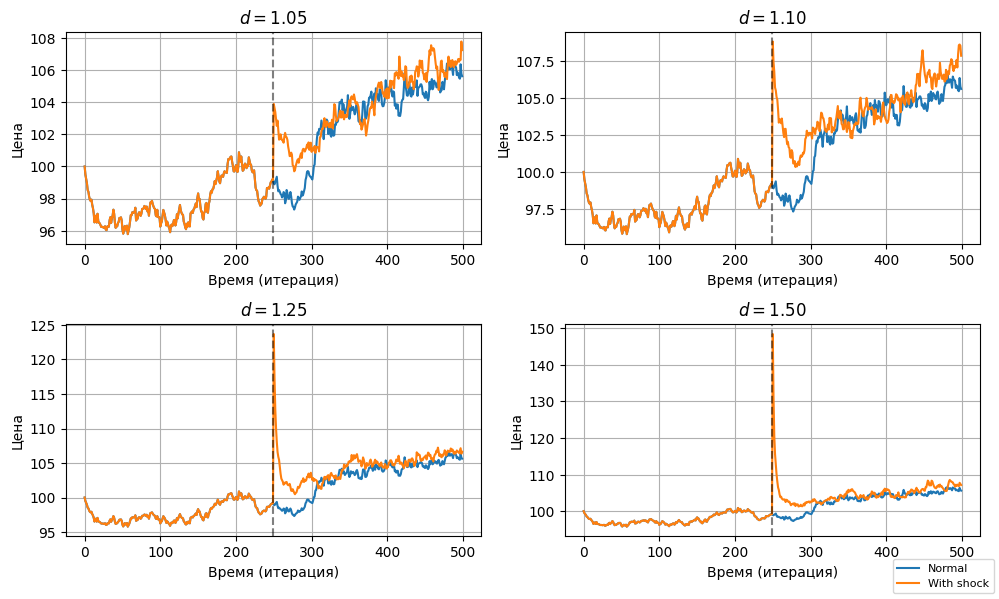

In [6]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
for (sc, eng), ax_ in zip(engines.items(), ax.flatten()):
    price = pd.Series(eng.stats_monitor.prices)
    p.plot(ax=ax_)
    price.plot(
        ax=ax_,
        ylabel="Цена",
        xlabel="Время (итерация)",
        title=f"$d = {sc:.2f}$",
        grid=True,
    )
    ax_.axvline(249, color="black", linestyle="--", alpha=0.5)
fig.legend(
    [
        "Normal",
        "With shock",
    ],
    loc=4,
    fontsize=8,
)
fig.tight_layout();

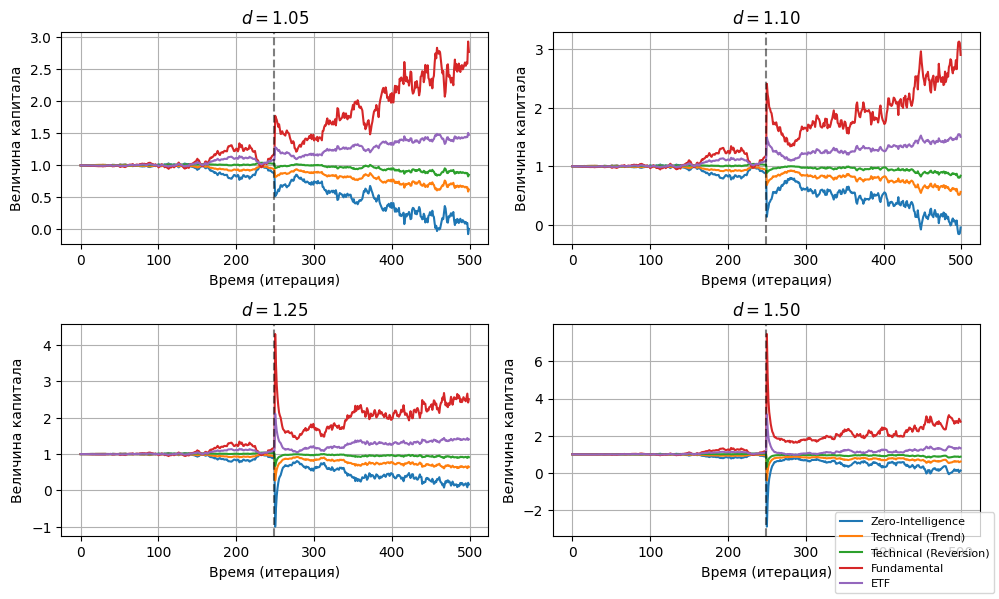

In [7]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
for (sc, eng), ax_ in zip(engines.items(), ax.flatten()):
    equity = pd.DataFrame(
        [
            [
                bs[ZeroIntelligenceTrader]["total_equity"],
                bs[TrendTrader]["total_equity"],
                bs[MeanReversionTrader]["total_equity"],
                bs[FundamentalTrader]["total_equity"],
                bs[ETFTrader]["total_equity"],
            ]
            for bs in eng.stats_monitor.balance_stats
        ],
    )
    (equity / equity.iloc[0].to_numpy()[None, :]).plot(
        ax=ax_,
        xlabel="Время (итерация)",
        ylabel="Величина капитала",
        title=f"$d = {sc:.2f}$",
        grid=True,
        legend=False,
    )
    ax_.axvline(249, color="black", linestyle="--", alpha=0.5);
fig.legend(
    [
        "Zero-Intelligence", 
        "Technical (Trend)", 
        "Technical (Reversion)", 
        "Fundamental", 
        "ETF",
    ],
    loc=4,
    fontsize=8,
)
fig.tight_layout();

## Проверка стилизованных фактов

### Лептокуртическое распределение доходности

In [8]:
for sc, eng in engines.items():
    price = pd.Series(eng.stats_monitor.prices)
    print(f"{sc:.2f}: {price.pct_change().kurt():.4f}")

1.05: 45.6360
1.10: 191.2262
1.25: 362.8424
1.50: 399.2875


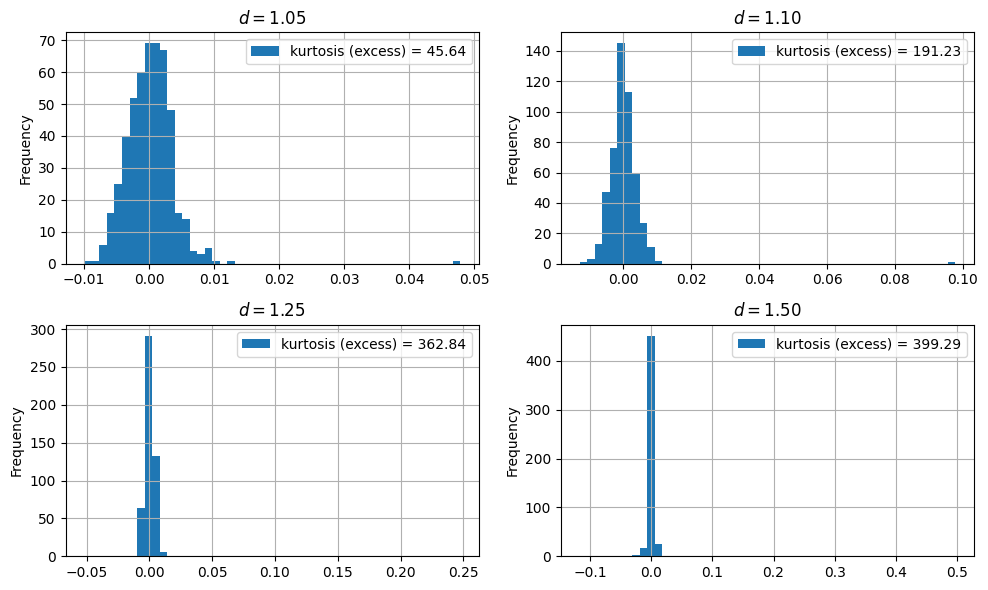

In [9]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
for (sc, eng), ax_ in zip(engines.items(), ax.flatten()):
    price = pd.Series(eng.stats_monitor.prices)
    price.pct_change().plot.hist(
        ax=ax_,
        bins=50,
        figsize=(10, 6),
        grid=True,
        title=f"$d = {sc:.2f}$"
    )
    ax_.legend([f"kurtosis (excess) = {price.pct_change().kurt():.2f}"]);
fig.tight_layout();

### Отсутствие автокорреляции доходностей

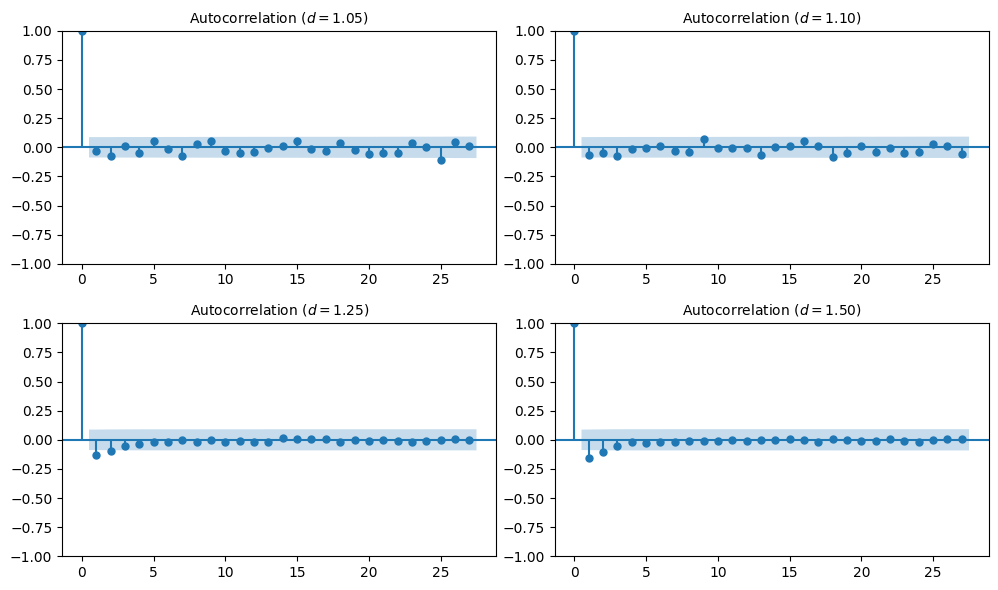

In [10]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
for (sc, eng), ax_ in zip(engines.items(), ax.flatten()):
    price = pd.Series(eng.stats_monitor.prices)
    plot_acf(price.pct_change().dropna(), ax=ax_)
    ax_.set_title(f"Autocorrelation ($d = {sc:.2f}$)", fontsize=10)
fig.tight_layout();

### Кластеризация волатильности

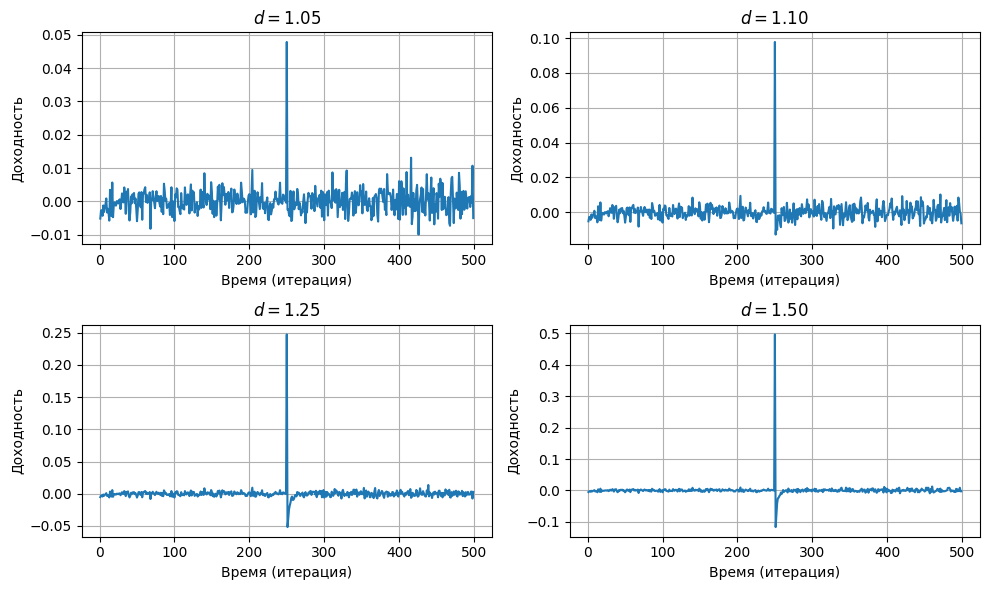

In [11]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
for (sc, eng), ax_ in zip(engines.items(), ax.flatten()):
    price = pd.Series(eng.stats_monitor.prices)
    price.pct_change().plot(
        ax=ax_,
        grid=True,
        figsize=(10, 6),
        title=f"$d = {sc:.2f}$",
        xlabel="Время (итерация)",
        ylabel="Доходность",
    )
fig.tight_layout();

### Асимметрия волатильности

In [12]:
for sc, eng in engines.items():
    volatility = pd.DataFrame(
        [(INITIAL_PRICE, None)] + [(ps["mean_weighted_price"], ps["std_price"]) for ps in eng.stats_monitor.period_stats],
        columns=["price", "std"],
    )
    volatility["returns"] = volatility["price"].pct_change()
    cor = volatility[["returns", "std"]].dropna().corr().iloc[0, 1]
    print(f"{sc:.2f}: {cor:.4f}")

1.05: 0.0239
1.10: 0.0877
1.25: 0.4957
1.50: 0.6418


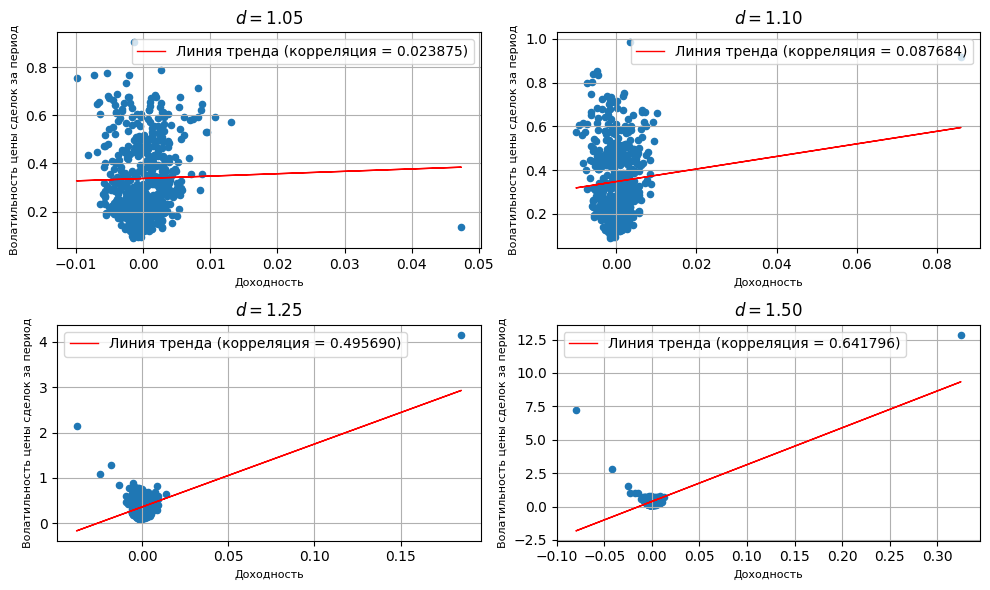

In [13]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
for (sc, eng), ax_ in zip(engines.items(), ax.flatten()):
    volatility = pd.DataFrame(
        [(INITIAL_PRICE, None)] 
        + [(ps["mean_weighted_price"], ps["std_price"]) for ps in eng.stats_monitor.period_stats],
        columns=["price", "std"],
    )
    volatility["returns"] = volatility["price"].pct_change()
    cor = volatility[["returns", "std"]].dropna().corr().iloc[0, 1]
    
    trend = np.poly1d(np.polyfit(volatility["returns"].dropna(), volatility["std"].dropna(), deg=1))

    volatility[["returns", "std"]].plot.scatter(
        x="returns", y="std", ax=ax_, 
        grid=True,
        title=f"$d = {sc:.2f}$",
    )
    ax_.set_xlabel("Доходность", fontsize=8)
    ax_.set_ylabel("Волатильность цены сделок за период", fontsize=8)

    ax_.plot(
        volatility["returns"].dropna(), 
        trend(volatility["returns"].dropna()), 
        linewidth=1, 
        color="r",
        label=f"Линия тренда (корреляция = {volatility[['returns', 'std']].dropna().corr().iloc[0, 1]:6f})"
    )
    ax_.legend();
fig.tight_layout();

### Автокорреляция торгового объема

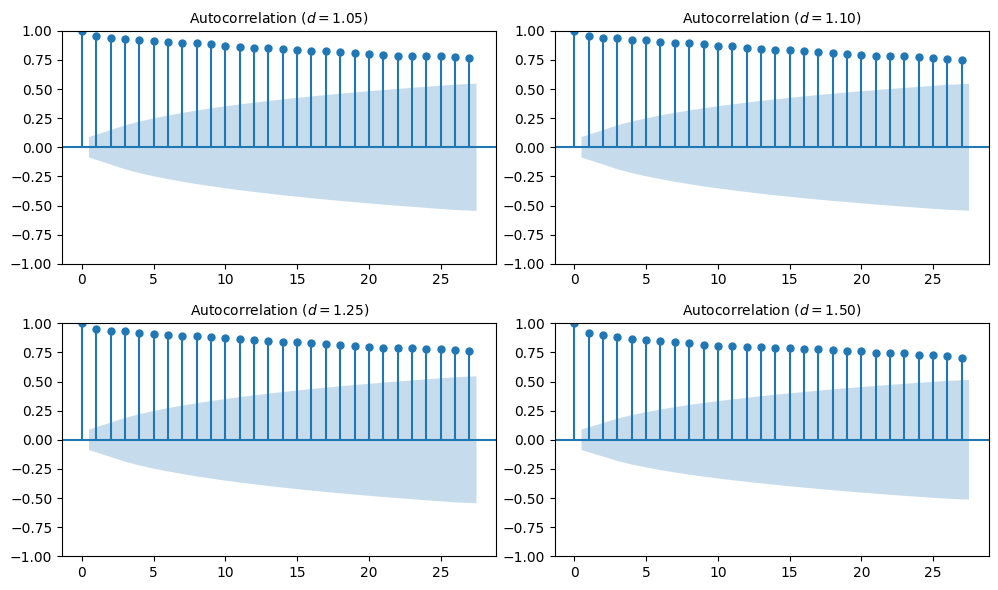

In [14]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
for (sc, eng), ax_ in zip(engines.items(), ax.flatten()):
    volumes = pd.Series([ps["total_quantity"] for ps in eng.stats_monitor.period_stats])
    plot_acf(volumes, ax=ax_)
    ax_.set_title(f"Autocorrelation ($d = {sc:.2f}$)", fontsize=10)
    plt.grid()
fig.tight_layout();

### Корреляция между торговым объемом и волатильностью

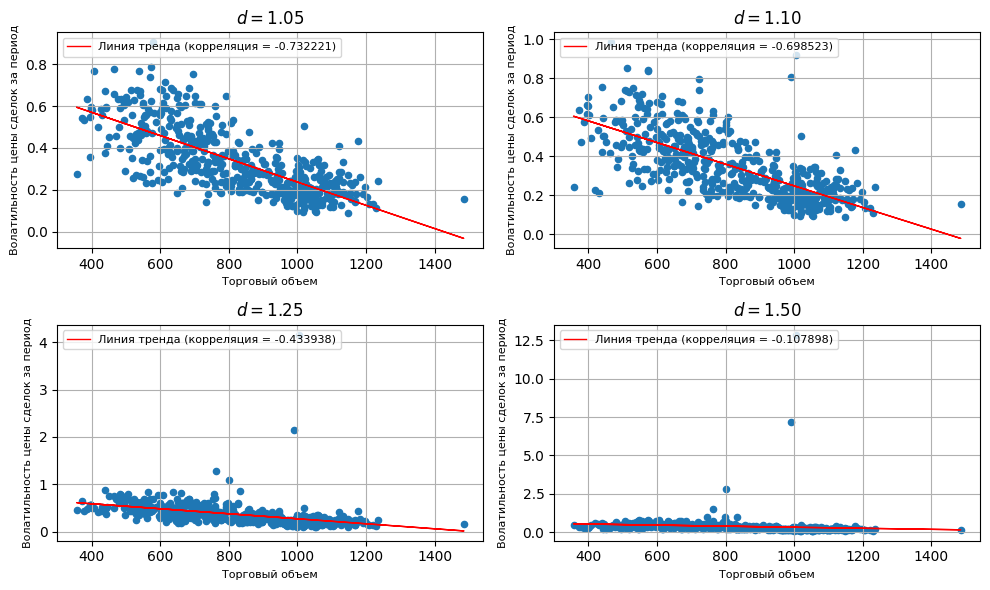

In [15]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
for (sc, eng), ax_ in zip(engines.items(), ax.flatten()):
    volatility = pd.DataFrame(
        [(INITIAL_PRICE, None)] 
        + [(ps["mean_weighted_price"], ps["std_price"]) for ps in eng.stats_monitor.period_stats],
        columns=["price", "std"],
    )
    volatility_volumes = pd.DataFrame()
    volatility_volumes["std"] = volatility["std"].dropna()
    volatility_volumes["volume"] = volumes
    volatility_volumes = volatility_volumes.dropna()
    
    trend = np.poly1d(np.polyfit(volatility_volumes["volume"].dropna(), volatility_volumes["std"].dropna(), deg=1))

    volatility_volumes[["volume", "std"]].plot.scatter(
        x="volume", y="std", ax=ax_, 
        grid=True,
        title=f"$d = {sc:.2f}$",
    )
    ax_.set_xlabel("Торговый объем", fontsize=8)
    ax_.set_ylabel("Волатильность цены сделок за период", fontsize=8)

    ax_.plot(
        volatility_volumes["volume"].dropna(), 
        trend(volatility_volumes["volume"].dropna()), 
        linewidth=1, 
        color="r",
        label=f"Линия тренда (корреляция = {volatility_volumes[['volume', 'std']].dropna().corr().iloc[0, 1]:6f})",
    )
    ax_.legend(loc=2, fontsize=8)
fig.tight_layout();